In [18]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (10,8)

from constant import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


mean:     -70.3			std:      4.62


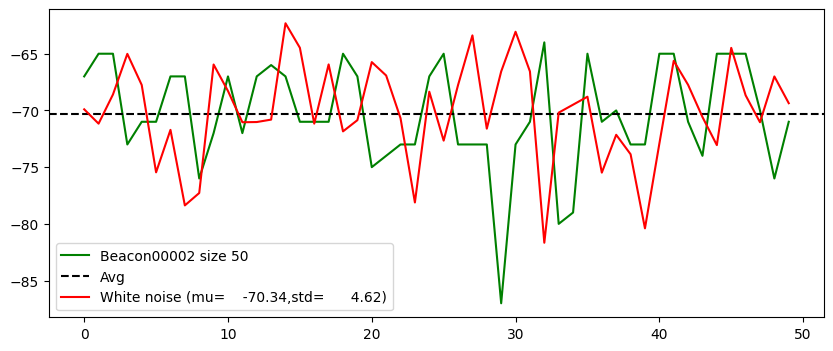

mean:     -69.8			std:      4.53


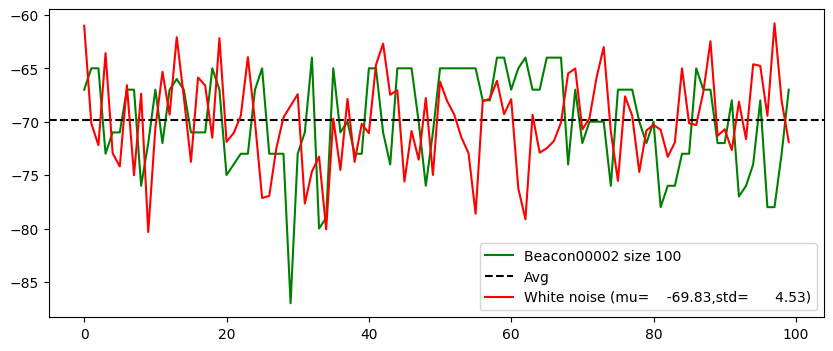

mean:     -70.4			std:      4.35


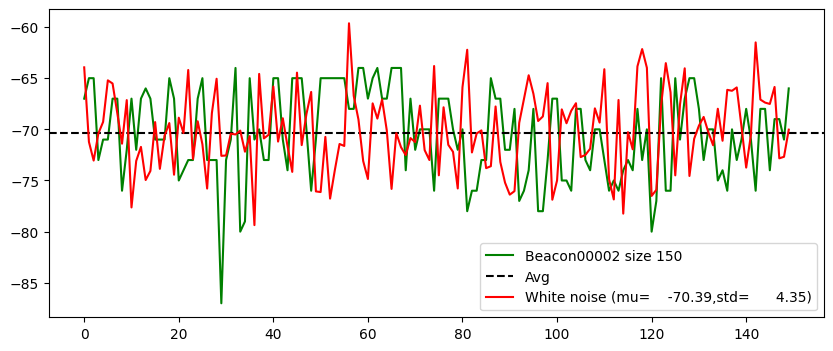

mean:     -70.6			std:      4.57


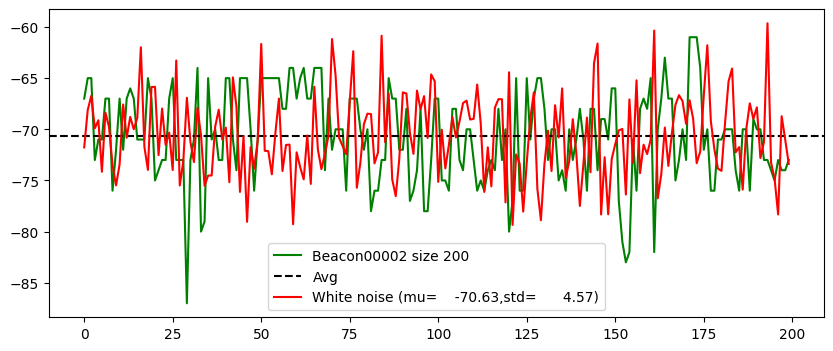

mean:     -70.6			std:      4.29


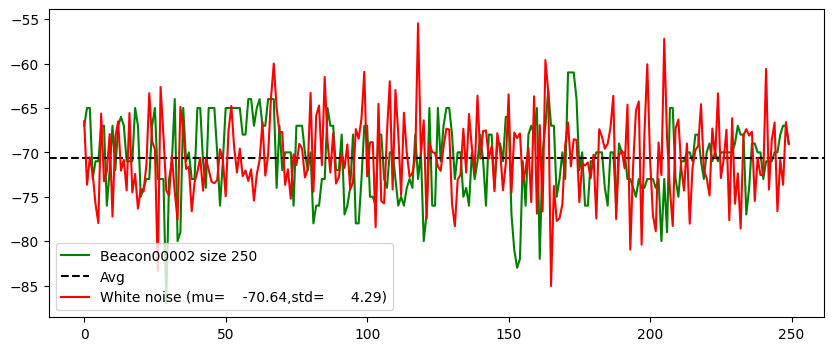

mean:     -70.4			std:      4.09


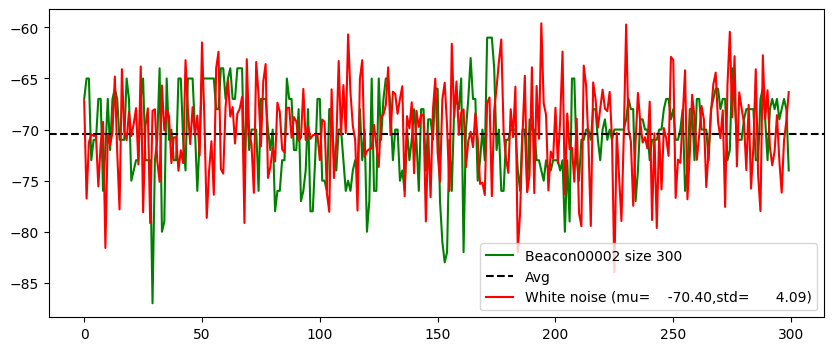

mean:     -70.4			std:      3.92


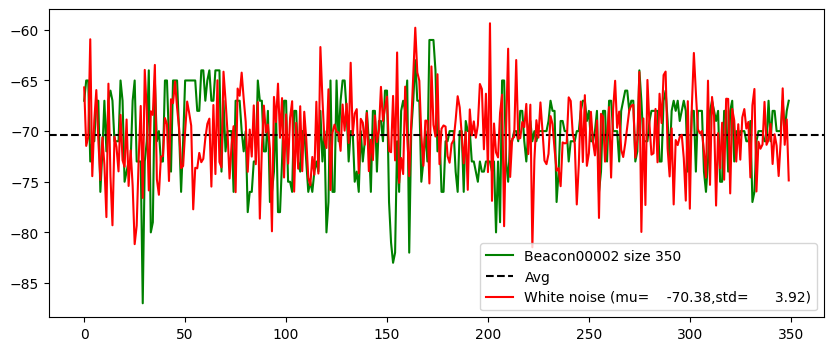

mean:     -70.3			std:       3.9


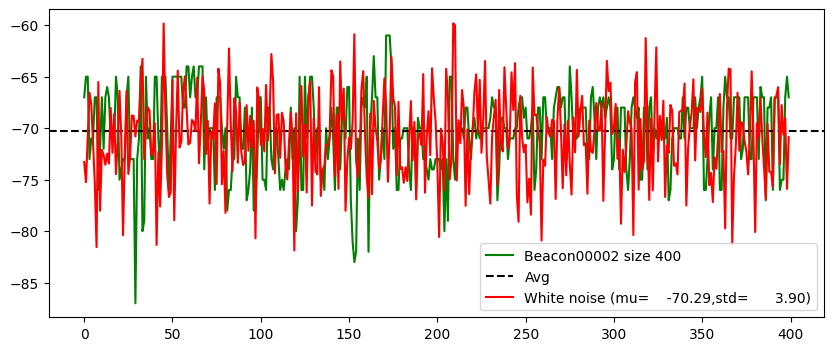

mean:     -70.1			std:      3.85


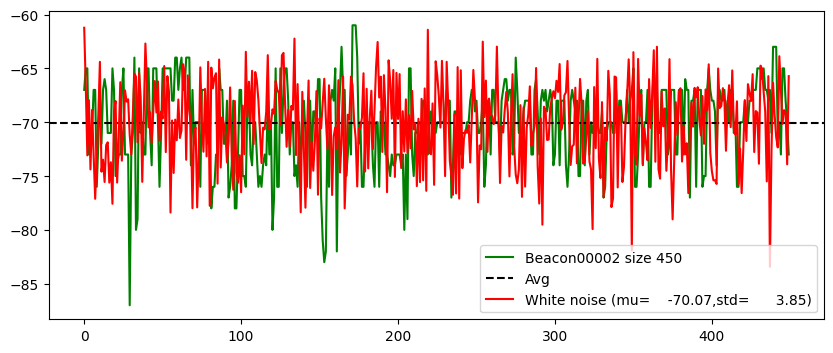

mean:     -70.0			std:      3.84


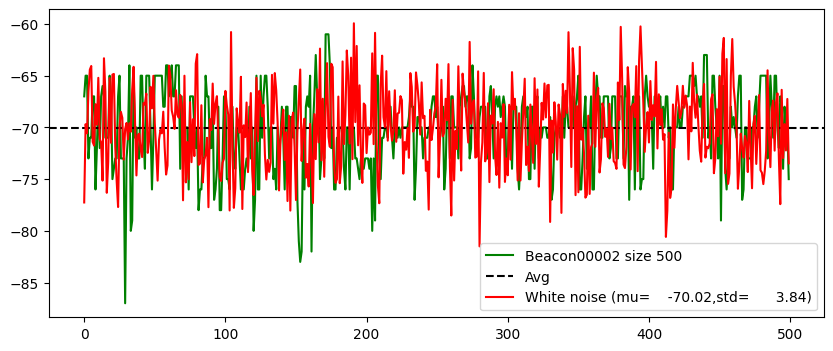

In [19]:
# BEACONS = np.array(['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006'])
BEACONS = np.array(['Beacon00002'])
from filterpy.common import Q_discrete_white_noise

beacon = 'Beacon00002'
rssi = np.array(RSSI500[beacon])
rssi_filter_js = np.array(RSSI500_FILTER[beacon])

def plot_white_noise(data, label=beacon):
    rssi_beacon = data
    print(f'mean:{rssi_beacon.mean():10.3}\t\t\tstd:{rssi_beacon.std():10.3}')

    plt.rcParams["figure.figsize"] = (10,4)
    plt.plot(list(range(rssi_beacon.size)), rssi_beacon, c='green', label=f'{label} size {rssi_beacon.size}')
    # plot mean line
    plt.axhline(y=np.nanmean(rssi_beacon), label='Avg', c='k', linestyle='--')

    # white noise
    mean = rssi_beacon.mean()
    std = rssi_beacon.std()
    num_samples = rssi_beacon.size
    samples = np.random.normal(mean, std, size=num_samples)
    plt.plot(samples,'r-', label=f'White noise (mu={mean:10.2f},std={std:10.2f})')
    plt.legend()
    plt.show()

step = 50
for i in range(step, rssi.size, step):
    rssi_beacon = rssi[:i]
    plot_white_noise(rssi_beacon)


# APPLY KALMAN FILTER

	x0	v0	var0		z		x	v	var
KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [[-60   0]].T
P = [[100   0]
     [  0   4]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.2]
     [0.  1. ]]
Q = [[4.e-06 4.e-05]
     [4.e-05 4.e-04]]
R = [[16.]]
H = [[1 0]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x0000014EFE521040>
     -60.0       0.0   100.160	     -67.0	     -66.0     -0.05 13.796143
     -66.0      -0.0    14.000	     -65.0	     -65.6     -0.02  7.466673
     -65.6      -0.0     7.819	     -65.0	     -65.4      0.01  5.252437
     -65.4       0.0     5.752	     -73.0	     -67.4      -0.6  4.230935
     -67.5      -0.6     4.864	     -71.0	     -68.3      -0.9  3.730154
     -68.5      -0.9     4.475	     -71.0	     -69.0    -1e+00  3.

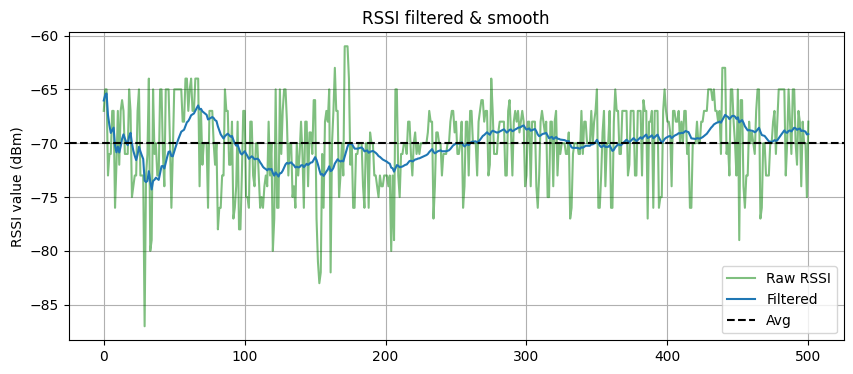

raw rssi {'mean': -70.01996007984032, 'std': 3.8333030631109617}
filtered {'mean': -70.0585300800456, 'std': 1.4983841488283067}
smooth	 {'mean': -70.01700214232974, 'std': 1.029242538338865}


In [20]:
from kalman import tracker1D, tracker2D, predict_rssi

def plot_filtered(rssi, rssi_filtered, rssi_smooth=None, rssi_var=None):
    ys = rssi
    ys_filtered = rssi_filtered
    xs = np.array(range(ys.size))
    xs_filtered = np.array(range(ys_filtered.size))

    # VISUALIZE
    if rssi_var is None:
        plt.rcParams["figure.figsize"] = (10,4)
        fig, axs = plt.subplots(1)
        ax = axs
    else:
        plt.rcParams["figure.figsize"] = (10,8)
        fig, axs = plt.subplots(2)
        ax = axs[0]
        ax_var = axs[1]
    # plot data
    ax.plot(xs, ys, 'g-',alpha=0.5, label="Raw RSSI")
    ax.plot(xs_filtered, ys_filtered, label="Filtered")
    if rssi_smooth is not None:
        ax.plot(xs, rssi_smooth, 'r-', label="Smooth Filtered")
    # mean line
    ax.axhline(y=np.nanmean(ys), label='Avg', c='k', linestyle='--')
    ax.set_title(f'RSSI filtered & smooth')
    ax.set_ylabel('RSSI value (dBm)')
    ax.legend()
    ax.grid()
    # plot var
    if rssi_var is not None:
        ys_var = rssi_var[:,0]
        xs_var = np.array(range(ys.size))
        ax_var.set_title(f'RSSI variance convergence')
        ax_var.plot(xs_var, ys_var, 'r-')
        ax_var.set_ylabel('RSSI variance (dBm)')
        ax_var.grid()
    plt.savefig('kf_smooth.png')
    plt.show()

rssi_filtered, rssi_var = predict_rssi(rssi)

kf = tracker2D(R=4**2, P=10**2, Q=0.5**2, X0=np.array([[-60,0]]))
mu, cov, _, _ = kf.batch_filter(rssi)
M, P, _, _ = kf.rts_smoother(mu, cov)
mu_smooth = np.array([x[0][0] for x in M])

plot_filtered(rssi, rssi_filtered)

print('raw rssi', {'mean':np.array(rssi).mean(), 'std':np.array(rssi).std() })
print('filtered', {'mean':rssi_filtered.mean(), 'std':rssi_filtered.std() })
print('smooth\t', {'mean':mu_smooth.mean(), 'std':mu_smooth.std() })


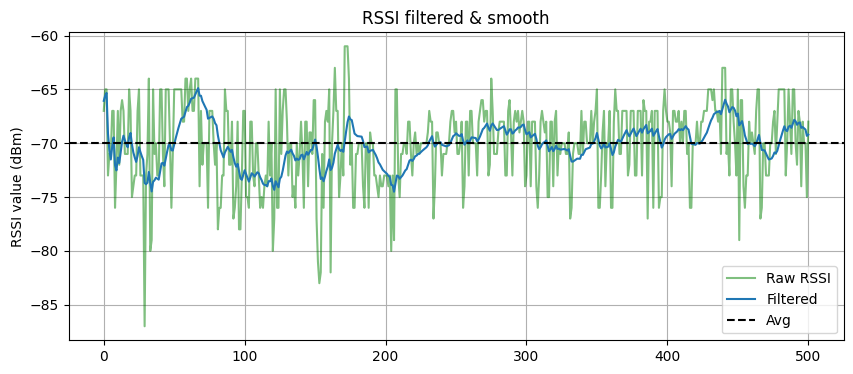

In [21]:
# kalman filter in javascript
plot_filtered(rssi, rssi_filter_js)
# plt.savefig('img/kf_js.png')